### Build and test a Nearest Neighbors classifier.

Load the relevant packages.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

Load the Iris data to use for experiments. The data include 50 observations of each of 3 types of irises (150 total). Each observation includes 4 measurements: sepal and petal width and height. The goal is to predict the iris type from these measurements.

<http://en.wikipedia.org/wiki/Iris_flower_data_set>

In [4]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [13]:
test_labels

array([0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0,
       0, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0,
       2, 1, 2, 0])

Create a distance function that returns the distance between 2 observations.

In [11]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

In [14]:
import inspect

inspect.getsourcelines(EuclideanDistance) 

([u'def EuclideanDistance(v1, v2):\n',
  u'    sum = 0.0\n',
  u'    for index in range(len(v1)):\n',
  u'        sum += (v1[index] - v2[index]) ** 2\n',
  u'    return sum ** 0.5\n'],
 1)

Just for fun, let's compute all the pairwise distances in the training data and plot a histogram.

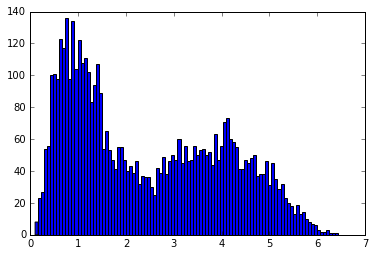

In [15]:
dists = []
for i in range(len(train_data) - 1):
    for j in range(i + 1, len(train_data)):
        dist = EuclideanDistance(train_data[i], train_data[j])
        dists.append(dist)
        
fig = plt.hist(dists, 100)

In [24]:
import pandas as pd

df = pd.DataFrame(dists)
df.head()

,0
0,0.100000
1,0.100000
2,0.141421
3,0.141421
4,0.141421


Ok now let's create a class that implements a Nearest Neighbors classifier. We'll model it after the sklearn classifier implementations, with fit() and predict() methods.

<http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier>

In [26]:
class NearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, metric=EuclideanDistance):
        self.metric = metric
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return results
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        best_dist, best_label = 1.0e10, None
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            if dist < best_dist:
                best_label = self.train_labels[i]
                best_dist = dist
        return best_label

Run an experiment with the classifier.

In [27]:
clf = NearestNeighbors()
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print 'total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)

total:  50  correct:  48  accuracy: 0.96


### k nearest neighbors

The implementation above only allows for a single nearest neighbor; that is, the classifier predicts the label of the closest available point. What about using more than one nearest neighbor. Typically, this means to make a prediciton we:

1. Find the k closest points (according to our distance metric) to the query point.
2. Find the majority label of those k points found in (1)
3. Return the label in (2) as the pre

In [49]:
class OurKNearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, k=3, metric=EuclideanDistance):
        self.metric = metric
        self.k = k
        
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data, k):
        results = []
        for item in test_data:
            results.append(self._predict_item(item, k))
        return results
    
    # Private function for making a single prediction.
    def _predict_item(self, item, k):
        distances = []
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            distances.append(self.train_data[i], dist)
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
        for x in range(k):
            neighbors.append(distances[x][0])
        for x in range(len(neighbors)):
            response = neighbors[x][-1]
            if response in classVotes:
                classVotes[response] +=1
            else:
                classVotes[response] = 1
        best_label = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
        return best_label[0][0]  
    

### Picking k: the number of neighbors to use in classification

If you did not do the above, you can use sklearn's nearest neighbors classifier for an implementation with multiple k

Implement a way to pick the number of neighbors to use in the classifier. We already have a test set, so simply extend the procedure in the previous code cell to run over different numbers of neighbors. Plot the test set performance versus the number of neighbors.

(note: you can use sklearn's implementation here; for a challenge, implement knn above [only 1-nn is implemented right now!])

In [51]:
clf = OurKNearestNeighbors()
clf.fit(train_data, train_labels)
preds = clf.predict(test_data,3)

TypeError: append() takes exactly one argument (2 given)

### Visualizing the results

We've been a litte haphazard so far, we should have plotted the data and some results to get an idea of how the algorithm is performing. Plot the data with the true labels as colors, and plot it with some fitted labels, for differing values of k, to see how our KNN algorithm is performing.

(50, 4)


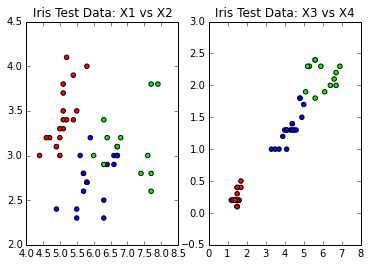

In [8]:
## code goes here!
print test_data.shape

cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
p = plt.subplot(1, 2, 1)
p.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=cm_bright)
plt.title("Iris Test Data: X1 vs X2")

p = plt.subplot(1, 2, 2)
p.scatter(test_data[:, 2], test_data[:, 3], c=test_labels, cmap=cm_bright)
plt.title("Iris Test Data: X3 vs X4")

### A different distance metric

We used the euclidean distance metric, try implementing another one. A couple of suggestions:

1. L1 (manhattan) distance
2. Lp distance ( https://en.wikipedia.org/wiki/Lp_space )
3. L-infinity distance
4. Try a metric that re-weights by dimension index, e.g. discard one dimension entirely

Do any of these improve or greatly affect the results? (Use the test set to back up any statements)

In [9]:
## code goes here!

# a reminder of what euclidean distance looks like
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5